## Anomaly Detection with Machine Learning

For an unsupervised approach, we don't have any labels, which is the most common case. The objective is to find the anomalies whose features differ from the normal observations significantly.

In [1]:
# Libraries
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn import linear_model, model_selection, metrics

from warnings import simplefilter
simplefilter(action='ignore')

from IPython.display import display, HTML

### 1. Data

In [2]:
# Download data to a dataframe
df = pd.read_csv(r"df_final.csv")

Some basic EDA and plotting the original data:

In [3]:
display(HTML(df.describe().T.to_html()))
# df.describe().T

,count,mean,std,min,25%,50%,75%,max
PotentialFraud,5343.0,0.094703,2.928322e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DeductibleAmtPaid,5343.0,6539.596107,2.008307e+04,0.000000,0.000000,240.000000,4292.000000,4.253580e+05
AdmitForDays,5343.0,40.226277,1.282776e+02,0.000000,0.000000,0.000000,26.000000,2.874000e+03
Gender,5343.0,131.972862,3.462451e+02,1.000000,13.000000,40.000000,112.000000,1.035900e+04
Race,5343.0,104.887142,2.936851e+02,1.000000,10.000000,32.000000,90.000000,1.040800e+04
RenalDiseaseIndicator,5343.0,16.411379,4.237879e+01,0.000000,1.000000,5.000000,14.000000,1.146000e+03
State,5343.0,2125.815647,5.714006e+03,2.000000,156.000000,535.000000,1694.500000,9.130200e+04
County,5343.0,31621.917088,8.696914e+04,0.000000,2350.000000,8401.000000,25352.500000,1.809761e+06
NoOfMonths_PartACov,5343.0,997.177241,2.619367e+03,0.000000,96.000000,300.000000,852.000000,7.853600e+04
NoOfMonths_PartBCov,5343.0,997.739847,2.620952e+03,0.000000,96.000000,300.000000,852.000000,7.882400e+04


In [4]:
df.Provider

0       PRV51001
1       PRV51003
2       PRV51004
3       PRV51005
4       PRV51007
          ...   
5338    PRV57759
5339    PRV57760
5340    PRV57761
5341    PRV57762
5342    PRV57763
Name: Provider, Length: 5343, dtype: object

In [5]:
df.set_index("Provider", inplace=True)

In [6]:
df

,PotentialFraud,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,count ClaimID per Provider & ClmDiagnosisCode_10,count ClaimID per Provider & DiagnosisGroupCode,count ClaimID per Provider & BeneID & AttendingPhysician,count ClaimID per Provider & BeneID & OtherPhysician,count ClaimID per Provider & BeneID & AttendingPhysician & ClmProcedureCode_1,count ClaimID per Provider & BeneID & AttendingPhysician & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & OperatingPhysician,count ClaimID per Provider & BeneID & ClmProcedureCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1 & ClmProcedureCode_1
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51001,0,3204.0,12.0,34,25,6,21,10300,252,252,...,0.0,3.0,21.0,8.0,1.0,20.0,4.0,1.0,20.0,1.0
PRV51003,1,52402.0,325.0,168,131,24,386,31251,1236,1236,...,5.0,53.0,106.0,22.0,32.0,104.0,38.0,32.0,104.0,32.0
PRV51004,0,310.0,0.0,205,151,18,1589,40810,1462,1476,...,0.0,0.0,123.0,51.0,0.0,117.0,25.0,0.0,117.0,0.0
PRV51005,1,2900.0,0.0,1463,1177,219,1245,457810,11268,11317,...,1.0,0.0,1564.0,501.0,0.0,935.0,201.0,0.0,945.0,0.0
PRV51007,0,3214.0,19.0,90,69,8,178,21540,684,684,...,1.0,3.0,64.0,24.0,1.0,58.0,9.0,1.0,58.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,0,130.0,0.0,30,36,3,990,8040,264,264,...,0.0,0.0,30.0,11.0,0.0,21.0,0.0,0.0,21.0,0.0
PRV57760,0,0.0,0.0,22,21,0,810,7570,216,210,...,0.0,0.0,44.0,17.0,0.0,18.0,4.0,0.0,18.0,0.0
PRV57761,0,370.0,0.0,103,81,19,680,27460,816,816,...,0.0,0.0,92.0,37.0,0.0,68.0,12.0,0.0,68.0,0.0


In [7]:
X = df.drop("PotentialFraud", axis=1)
y = df["PotentialFraud"]

In [8]:
y.value_counts()

0    4837
1     506
Name: PotentialFraud, dtype: int64

### 2. Models

#### 2.1 Clustering




In [9]:
# Return a series of distances between each data point and the closest centroid
def getDistance(data, model):
    distance = pd.Series()
    for i in range(len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [10]:
# Standardize the data
data = X.copy()
scaled = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled)

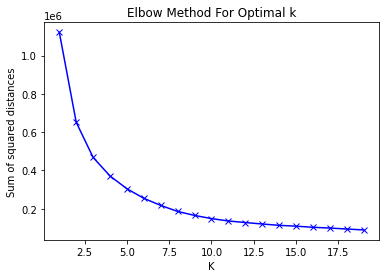

Wall time: 17.9 s


In [11]:
%%time

# Plot to find optimal k (elbow method)
Sum_of_squared_distances = []
km_models = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k).fit(data)
    km_models.append(km)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
%%time

# Anomly population estimated to: 10%
# You can set to different values to view different results
anomaly_fraction = 0.10

distances = getDistance(data, km_models[2])
number_of_anomalies = int(anomaly_fraction*len(data))

# Farrest points are considered anomalies
threshold = distances.nlargest(number_of_anomalies).min()

df.reset_index(inplace=True)
df = df.join(pd.DataFrame((distances >= threshold).astype(int)).rename({0: "kmeans_anomaly"}, axis=1))

Wall time: 2.53 s


In [13]:
df

,Provider,PotentialFraud,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,...,count ClaimID per Provider & DiagnosisGroupCode,count ClaimID per Provider & BeneID & AttendingPhysician,count ClaimID per Provider & BeneID & OtherPhysician,count ClaimID per Provider & BeneID & AttendingPhysician & ClmProcedureCode_1,count ClaimID per Provider & BeneID & AttendingPhysician & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & OperatingPhysician,count ClaimID per Provider & BeneID & ClmProcedureCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1 & ClmProcedureCode_1,kmeans_anomaly
0,PRV51001,0,3204.0,12.0,34,25,6,21,10300,252,...,3.0,21.0,8.0,1.0,20.0,4.0,1.0,20.0,1.0,0
1,PRV51003,1,52402.0,325.0,168,131,24,386,31251,1236,...,53.0,106.0,22.0,32.0,104.0,38.0,32.0,104.0,32.0,1
2,PRV51004,0,310.0,0.0,205,151,18,1589,40810,1462,...,0.0,123.0,51.0,0.0,117.0,25.0,0.0,117.0,0.0,0
3,PRV51005,1,2900.0,0.0,1463,1177,219,1245,457810,11268,...,0.0,1564.0,501.0,0.0,935.0,201.0,0.0,945.0,0.0,1
4,PRV51007,0,3214.0,19.0,90,69,8,178,21540,684,...,3.0,64.0,24.0,1.0,58.0,9.0,1.0,58.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338,PRV57759,0,130.0,0.0,30,36,3,990,8040,264,...,0.0,30.0,11.0,0.0,21.0,0.0,0.0,21.0,0.0,0
5339,PRV57760,0,0.0,0.0,22,21,0,810,7570,216,...,0.0,44.0,17.0,0.0,18.0,4.0,0.0,18.0,0.0,0
5340,PRV57761,0,370.0,0.0,103,81,19,680,27460,816,...,0.0,92.0,37.0,0.0,68.0,12.0,0.0,68.0,0.0,0
5341,PRV57762,0,0.0,0.0,1,1,0,21,230,12,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


In [14]:
cf_matrix = metrics.confusion_matrix(y, df.kmeans_anomaly)
accuracy = metrics.accuracy_score(y, df.kmeans_anomaly)
precision = metrics.precision_score(y, df.kmeans_anomaly)
recall = metrics.recall_score(y, df.kmeans_anomaly)

report = f'The evaluation report is ==>\n Confusion Matrix:\n {cf_matrix} \nAccuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall}'
print(report)

The evaluation report is ==>
 Confusion Matrix:
 [[4539  298]
 [ 270  236]] 
Accuracy: 0.8936926820138499 
Precision: 0.4419475655430712 
Recall: 0.466403162055336


#### 2.2 Isolation Forest

In [15]:
df

,Provider,PotentialFraud,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,...,count ClaimID per Provider & DiagnosisGroupCode,count ClaimID per Provider & BeneID & AttendingPhysician,count ClaimID per Provider & BeneID & OtherPhysician,count ClaimID per Provider & BeneID & AttendingPhysician & ClmProcedureCode_1,count ClaimID per Provider & BeneID & AttendingPhysician & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & OperatingPhysician,count ClaimID per Provider & BeneID & ClmProcedureCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1 & ClmProcedureCode_1,kmeans_anomaly
0,PRV51001,0,3204.0,12.0,34,25,6,21,10300,252,...,3.0,21.0,8.0,1.0,20.0,4.0,1.0,20.0,1.0,0
1,PRV51003,1,52402.0,325.0,168,131,24,386,31251,1236,...,53.0,106.0,22.0,32.0,104.0,38.0,32.0,104.0,32.0,1
2,PRV51004,0,310.0,0.0,205,151,18,1589,40810,1462,...,0.0,123.0,51.0,0.0,117.0,25.0,0.0,117.0,0.0,0
3,PRV51005,1,2900.0,0.0,1463,1177,219,1245,457810,11268,...,0.0,1564.0,501.0,0.0,935.0,201.0,0.0,945.0,0.0,1
4,PRV51007,0,3214.0,19.0,90,69,8,178,21540,684,...,3.0,64.0,24.0,1.0,58.0,9.0,1.0,58.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338,PRV57759,0,130.0,0.0,30,36,3,990,8040,264,...,0.0,30.0,11.0,0.0,21.0,0.0,0.0,21.0,0.0,0
5339,PRV57760,0,0.0,0.0,22,21,0,810,7570,216,...,0.0,44.0,17.0,0.0,18.0,4.0,0.0,18.0,0.0,0
5340,PRV57761,0,370.0,0.0,103,81,19,680,27460,816,...,0.0,92.0,37.0,0.0,68.0,12.0,0.0,68.0,0.0,0
5341,PRV57762,0,0.0,0.0,1,1,0,21,230,12,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


In [16]:
%%time

# Standardize the data
data = X.copy()
scaled = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled)

# Train isolation forest
anomaly_fraction = 0.10
######################################################################
# 1. Train the iForest model (sklearn.ensemble.IsolationForest) with 
# standardized data;
max_features=1.0
n_estimators=50
max_samples='auto'
contamination=float(anomaly_fraction)
forest_model=IsolationForest(max_features = max_features, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
forest_model.fit(data)
# 2. Calculate the prediction 
df['isolation_forest_anomaly']=forest_model.predict(data)
df['isolation_forest_anomaly'].replace([1, -1], [0, 1], inplace=True)
df.head(10)

Wall time: 1.27 s


,Provider,PotentialFraud,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,...,count ClaimID per Provider & BeneID & AttendingPhysician,count ClaimID per Provider & BeneID & OtherPhysician,count ClaimID per Provider & BeneID & AttendingPhysician & ClmProcedureCode_1,count ClaimID per Provider & BeneID & AttendingPhysician & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & OperatingPhysician,count ClaimID per Provider & BeneID & ClmProcedureCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1 & ClmProcedureCode_1,kmeans_anomaly,isolation_forest_anomaly
0,PRV51001,0,3204.0,12.0,34,25,6,21,10300,252,...,21.0,8.0,1.0,20.0,4.0,1.0,20.0,1.0,0,0
1,PRV51003,1,52402.0,325.0,168,131,24,386,31251,1236,...,106.0,22.0,32.0,104.0,38.0,32.0,104.0,32.0,1,1
2,PRV51004,0,310.0,0.0,205,151,18,1589,40810,1462,...,123.0,51.0,0.0,117.0,25.0,0.0,117.0,0.0,0,0
3,PRV51005,1,2900.0,0.0,1463,1177,219,1245,457810,11268,...,1564.0,501.0,0.0,935.0,201.0,0.0,945.0,0.0,1,1
4,PRV51007,0,3214.0,19.0,90,69,8,178,21540,684,...,64.0,24.0,1.0,58.0,9.0,1.0,58.0,1.0,0,0
5,PRV51008,0,1148.0,4.0,56,43,9,145,21820,420,...,35.0,16.0,1.0,35.0,5.0,1.0,35.0,1.0,0,0
6,PRV51011,0,1228.0,6.0,71,51,10,45,13320,540,...,45.0,16.0,0.0,40.0,8.0,0.0,40.0,0.0,0,0
7,PRV51012,0,100.0,0.0,72,46,6,83,10690,492,...,44.0,15.0,0.0,40.0,8.0,0.0,41.0,0.0,0,0
8,PRV51013,0,230.0,0.0,59,35,8,150,6300,396,...,33.0,13.0,0.0,32.0,8.0,0.0,32.0,0.0,0,0
9,PRV51014,0,120.0,0.0,49,30,8,68,10920,336,...,29.0,18.0,0.0,27.0,9.0,0.0,28.0,0.0,0,0


In [17]:
cf_matrix = metrics.confusion_matrix(y, df.isolation_forest_anomaly)
accuracy = metrics.accuracy_score(y, df.isolation_forest_anomaly)
precision = metrics.precision_score(y, df.isolation_forest_anomaly)
recall = metrics.recall_score(y, df.isolation_forest_anomaly)

report = f'The evaluation report is ==>\n Confusion Matrix:\n {cf_matrix} \nAccuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall}'
print(report)

The evaluation report is ==>
 Confusion Matrix:
 [[4572  265]
 [ 236  270]] 
Accuracy: 0.9062324536777091 
Precision: 0.5046728971962616 
Recall: 0.5335968379446641


#### 2.3 OCSVM


In [18]:
%%time

######################################################################
# 1. Standardize the data if you think necessary;
data = X.copy()
scaled = StandardScaler().fit_transform(data)
data = pd.DataFrame(scaled)

# 2. Train the OC SVM model (sklearn.svm.OneClassSVM) and get anomaly 
# prediction;
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.10)
ocsvm.fit(data)
df['one_class_svm_anomaly']=ocsvm.predict(data)
df['one_class_svm_anomaly'].replace([1, -1], [0, 1], inplace=True)
df.head(10)

Wall time: 2.07 s


,Provider,PotentialFraud,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,...,count ClaimID per Provider & BeneID & OtherPhysician,count ClaimID per Provider & BeneID & AttendingPhysician & ClmProcedureCode_1,count ClaimID per Provider & BeneID & AttendingPhysician & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & OperatingPhysician,count ClaimID per Provider & BeneID & ClmProcedureCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1,count ClaimID per Provider & BeneID & ClmDiagnosisCode_1 & ClmProcedureCode_1,kmeans_anomaly,isolation_forest_anomaly,one_class_svm_anomaly
0,PRV51001,0,3204.0,12.0,34,25,6,21,10300,252,...,8.0,1.0,20.0,4.0,1.0,20.0,1.0,0,0,0
1,PRV51003,1,52402.0,325.0,168,131,24,386,31251,1236,...,22.0,32.0,104.0,38.0,32.0,104.0,32.0,1,1,0
2,PRV51004,0,310.0,0.0,205,151,18,1589,40810,1462,...,51.0,0.0,117.0,25.0,0.0,117.0,0.0,0,0,0
3,PRV51005,1,2900.0,0.0,1463,1177,219,1245,457810,11268,...,501.0,0.0,935.0,201.0,0.0,945.0,0.0,1,1,1
4,PRV51007,0,3214.0,19.0,90,69,8,178,21540,684,...,24.0,1.0,58.0,9.0,1.0,58.0,1.0,0,0,0
5,PRV51008,0,1148.0,4.0,56,43,9,145,21820,420,...,16.0,1.0,35.0,5.0,1.0,35.0,1.0,0,0,0
6,PRV51011,0,1228.0,6.0,71,51,10,45,13320,540,...,16.0,0.0,40.0,8.0,0.0,40.0,0.0,0,0,0
7,PRV51012,0,100.0,0.0,72,46,6,83,10690,492,...,15.0,0.0,40.0,8.0,0.0,41.0,0.0,0,0,0
8,PRV51013,0,230.0,0.0,59,35,8,150,6300,396,...,13.0,0.0,32.0,8.0,0.0,32.0,0.0,0,0,0
9,PRV51014,0,120.0,0.0,49,30,8,68,10920,336,...,18.0,0.0,27.0,9.0,0.0,28.0,0.0,0,0,0


In [19]:
df.one_class_svm_anomaly.value_counts()

0    4808
1     535
Name: one_class_svm_anomaly, dtype: int64

In [20]:
cf_matrix = metrics.confusion_matrix(y, df.one_class_svm_anomaly)
accuracy = metrics.accuracy_score(y, df.one_class_svm_anomaly)
precision = metrics.precision_score(y, df.one_class_svm_anomaly)
recall = metrics.recall_score(y, df.one_class_svm_anomaly)

report = f'The evaluation report is ==>\n Confusion Matrix:\n {cf_matrix} \nAccuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall}'
print(report)

The evaluation report is ==>
 Confusion Matrix:
 [[4520  317]
 [ 288  218]] 
Accuracy: 0.8867677334830619 
Precision: 0.4074766355140187 
Recall: 0.4308300395256917


In [21]:
models = ["kmeans_anomaly", "isolation_forest_anomaly", "one_class_svm_anomaly"]

for model in models:
    cf_matrix = metrics.confusion_matrix(y, df[model])
    accuracy = metrics.accuracy_score(y, df[model])
    precision = metrics.precision_score(y, df[model])
    recall = metrics.recall_score(y, df[model])

    report = f'The evaluation report is: \nConfusion Matrix: \n{cf_matrix} \nAccuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall}'

    print('This report is for {}'.format(model))
    print(report)
    print("="*100)

This report is for kmeans_anomaly
The evaluation report is: 
Confusion Matrix: 
[[4539  298]
 [ 270  236]] 
Accuracy: 0.8936926820138499 
Precision: 0.4419475655430712 
Recall: 0.466403162055336
This report is for isolation_forest_anomaly
The evaluation report is: 
Confusion Matrix: 
[[4572  265]
 [ 236  270]] 
Accuracy: 0.9062324536777091 
Precision: 0.5046728971962616 
Recall: 0.5335968379446641
This report is for one_class_svm_anomaly
The evaluation report is: 
Confusion Matrix: 
[[4520  317]
 [ 288  218]] 
Accuracy: 0.8867677334830619 
Precision: 0.4074766355140187 
Recall: 0.4308300395256917
